## This notebook check the hexapod state transitions and move/offset commands
## It also checks the LUT against the input polynomials, before and after a slew

This notebook works with both hexapods.

Prerequisits:

The MTMount and the MTRotator must send telemetry for mount azimuth and elevation and rotation angle.

In [7]:
from lsst.ts import salobj
import asyncio
import os
import yaml

import numpy as np
from matplotlib import pyplot as plt
from astropy.time import Time
from datetime import datetime, timedelta
import pandas as pd

from lsst.ts.idl.enums import MTPtg
from lsst.ts.idl.enums import MTHexapod

from astropy.coordinates import AltAz, ICRS, EarthLocation, Angle, FK5
import astropy.units as u

from lsst_efd_client import EfdClient

import types

#from aosTools import *

In [41]:
async def readyHexaForAOS(hexa):
    settings = await hexa.evt_settingsApplied.aget(timeout = 10.)
    hasSettings = 0
    if hasattr(settings, 'settingsVersion'):
        print('settingsVersion = ', settings.settingsVersion, pd.to_datetime(settings.private_sndStamp, unit='s'))
        hasSettings = 1
    if (not hasSettings) or (not settings.settingsVersion[:12] == 'default.yaml'):
        print('YOU NEED TO SEND THIS HEXAPOD TO STANDBY, THEN LOAD THE PROPER CONFIG')
    else:
        hexaConfig = await hexa.evt_configuration.aget(timeout=10.)
        print("pivot at (%.0f, %.0f, %.0f) microns "%(hexaConfig.pivotX, hexaConfig.pivotY, hexaConfig.pivotZ))
        print("maxXY = ", hexaConfig.maxXY, "microns, maxZ= ", hexaConfig.maxZ, " microns")
        print("maxUV = ", hexaConfig.maxUV, "deg, maxW= ", hexaConfig.maxW, " deg")

        lutMode = await hexa.evt_compensationMode.aget(timeout=10)
        if not lutMode.enabled:
            hexa.evt_compensationMode.flush()
            await hexa.cmd_setCompensationMode.set_start(enable=1, timeout=10)
            lutMode = await hexa.evt_compensationMode.next(flush=False, timeout=10)
        print("compsensation mode enabled?",lutMode.enabled, pd.to_datetime(lutMode.private_sndStamp, unit='s'))
        #await moveHexaTo0(hexa, user_z = 100)
        #await moveHexaTo0(hexa)
        await printHexaUncompensatedAndCompensated(hexa)
        print("Does the hexapod has enough inputs to do LUT compensation? (If the below times out, we do not.)")
        #Note: the target events are what the hexa CSC checks; if one is missing, the entire LUT will not be applied
        #it also needs to see an uncompensatedPosition (a move would trigger that) in order to move to the compensatedPosition
        a = await hexa.evt_compensationOffset.aget(timeout=10.)
        print('mount elevation = ', a.elevation)
        print('mount azimth = ', a.azimuth)
        print('rotator angle = ', a.rotation)
        print('? temperature = ', a.temperature)
        print('x,y,z,u,v,w = ', a.x, a.y, a.z, a.u, a.v, a.w)


In [37]:
async def moveHexaTo0(hexa, user_z = 0):
    ### command it to collimated position (based on LUT), or with offset user_z
    
    hexa.evt_inPosition.flush()
    #according to XML, units are micron and degree
    await hexa.cmd_move.set_start(x=0,y=0,z=user_z, u=0,v=0,w=0,sync=True)
    while True:
        state = await hexa.evt_inPosition.next(flush=False, timeout=10)
        print("hexa in position?",state.inPosition, pd.to_datetime(state.private_sndStamp, unit='s'))
        if state.inPosition:
            break
    await printHexaPosition(hexa)

In [39]:
async def printHexaPosition(hexa):
    pos = await hexa.tel_application.next(flush=True, timeout=10.)
    print("Current Hexapod position")
    print(" ".join(f"{p:10.2f}" for p in pos.position[:3]), end = ' ') 
    print(" ".join(f"{p:10.6f}" for p in pos.position[3:]) )
    
async def printHexaUncompensatedAndCompensated(hexa):
    posU = await hexa.evt_uncompensatedPosition.aget(timeout=10.)
    print('Uncompensated position')
    print(" ".join(f"{p:10.2f}" for p in [getattr(posU, i) for i in 'xyz']), end = '    ')
    print(" ".join(f"{p:10.6f}" for p in [getattr(posU, i) for i in 'uvw']),'  ',
         pd.to_datetime(posU.private_sndStamp, unit='s'))    
    posC = await hexa.evt_compensatedPosition.aget(timeout=10.)
    print('Compensated position')
    print(" ".join(f"{p:10.2f}" for p in [getattr(posC, i) for i in 'xyz']), end = '     ')
    print(" ".join(f"{p:10.6f}" for p in [getattr(posC, i) for i in 'uvw']),'  ',
         pd.to_datetime(posC.private_sndStamp, unit='s'))

In [9]:
#os.environ["LSST_DDS_HISTORYSYNC"] = "30"

To switch between the hexapods, change the cell below.

In [10]:
import os
print(os.environ["OSPL_URI"])
if os.environ.get("LSST_DDS_ALIGNER", "false") != "false":
    print("LSST_DDS_ALIGNER is mis-configured")

file:///home/hdrass/WORK/ts_ddsconfig/config/ospl-shmem.xml


In [11]:
script = salobj.Controller("Script", index=42658887)

In [12]:
await asyncio.gather(script.start_task)

[None]

In [13]:
# Dict of short name: full SAL component name and index;
# comment out an etry to avoid making the associated remote:
remote_names = dict(
    # Always comment out one of the two hexapods:
    mthex=f"MTHexapod:{MTHexapod.SalIndex.CAMERA_HEXAPOD}",
    # mthex=f"MTHexapod:{MTHexapod.SalIndex.M2_HEXAPOD}",
    mtptg="MTPtg",
    mtrot="MTRotator",
    mtm="MTMount"
    )

In [14]:
remotes_dict = {}
for short_name, sal_name_index in remote_names.items():
    sal_name, index = salobj.name_to_name_index(sal_name_index)
    remote = salobj.Remote(domain=script.domain, name=sal_name, index=index)
    remotes_dict[short_name] = remote 
r = types.SimpleNamespace(**remotes_dict)
del remotes_dict  # use vars® instead
hexId = r.mthex.salinfo.index  # or just use the long form

In [15]:
print(hexId)

1


In [16]:
# Wait for all remotes to start
for remote in vars(r).values():
    await remote.start_task

# Wait for a heartbeat from each remote
for name, remote in vars(r).items():
    try:
        await remote.evt_heartbeat.next(flush=False, timeout=5)
    except asyncio.TimeoutError:
         print(f"No heartbeat seen for {remote.salinfo.name_index}")

rotation DDS read queue is filling: 25 of 100 elements
electrical DDS read queue is full (100 elements); data may be lost
motors DDS read queue is filling: 25 of 100 elements
application DDS read queue is full (100 elements); data may be lost
electrical DDS read queue is filling: 26 of 100 elements
actuators DDS read queue is full (100 elements); data may be lost
ccwFollowingError DDS read queue is filling: 27 of 100 elements
timeAndDate DDS read queue is filling: 24 of 100 elements
mountStatus DDS read queue is filling: 26 of 100 elements
mountPosition DDS read queue is filling: 26 of 100 elements


### Test the hexapod state transitions. If the hexapod is already enabled, disable then enable it.

In [17]:
state = await r.mthex.evt_summaryState.aget(timeout=5)
print('staring with: hex state', salobj.State(state.summaryState), pd.to_datetime(state.private_sndStamp, unit='s'))
if state.summaryState == 2:
    await salobj.set_summary_state(r.mthex, salobj.State.DISABLED) #disable hex

currentTargetStatus DDS read queue is filling: 27 of 100 elements


staring with: hex state State.ENABLED 2021-07-09 19:51:54.209679360


In [34]:
await salobj.set_summary_state(remote=r.mthex, state=salobj.State.STANDBY)

[<State.ENABLED: 2>, <State.DISABLED: 1>, <State.STANDBY: 5>]

In [31]:
await salobj.set_summary_state(remote=r.mthex, state=salobj.State.DISABLED)

[<State.STANDBY: 5>, <State.DISABLED: 1>]

In [35]:
await salobj.set_summary_state(r.mthex, salobj.State.ENABLED, settingsToApply="default") #enable hex

[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]

## Start the EFD client

In [22]:
#client = EfdClient('summit_efd')
client = EfdClient('ncsa_teststand_efd')

In [23]:
# the next line only work if information were sent to the EFD during the time span "timedelta"!
#we cannot get time series data from DDS. We have to query the EFD
#to check messages in Kafka, go to https://lsst-kafka-0-nts-efd.ncsa.illinois.edu/
csc_index = 1
end = Time(datetime.now(), scale='tai')
start = end - timedelta(hours=6)
while True: #may need to wait a few seconds before event shows up in EFD
    dfe = await client.select_time_series('lsst.sal.MTHexapod.logevent_summaryState', '*', start, end, csc_index)
    if len(dfe)>0:
        break

In [24]:
dfe

,MTHexapodID,priority,private_efdStamp,private_host,private_identity,private_kafkaStamp,private_origin,private_rcvStamp,private_revCode,private_seqNum,private_sndStamp,summaryState
2021-07-09 18:31:50.137000+00:00,1,0,1.625855e+09,0,MTHexapod:1,1.625856e+09,8867,1.625856e+09,959a0a03,37,1.625856e+09,1
2021-07-09 18:32:28.693000+00:00,1,0,1.625856e+09,0,MTHexapod:1,1.625856e+09,8867,1.625856e+09,959a0a03,38,1.625856e+09,5
2021-07-09 18:32:30.006000+00:00,1,0,1.625856e+09,0,MTHexapod:1,1.625856e+09,8867,1.625856e+09,959a0a03,39,1.625856e+09,1
2021-07-09 18:32:32.530000+00:00,1,0,1.625856e+09,0,MTHexapod:1,1.625856e+09,8867,1.625856e+09,959a0a03,40,1.625856e+09,2
2021-07-09 18:37:54.610000+00:00,1,0,1.625856e+09,0,MTHexapod:1,1.625856e+09,8867,1.625856e+09,959a0a03,41,1.625856e+09,1
2021-07-09 18:37:56.734000+00:00,1,0,1.625856e+09,0,MTHexapod:1,1.625856e+09,8867,1.625856e+09,959a0a03,42,1.625856e+09,5
2021-07-09 18:37:57.341000+00:00,1,0,1.625856e+09,0,MTHexapod:1,1.625856e+09,8867,1.625856e+09,959a0a03,43,1.625856e+09,1
2021-07-09 18:37:57.644000+00:00,1,0,1.625856e+09,0,MTHexapod:1,1.625856e+09,8867,1.625856e+09,959a0a03,44,1.625856e+09,2
2021-07-09 18:44:00.294000+00:00,1,0,1.625856e+09,0,MTHexapod:1,1.625856e+09,8867,1.625856e+09,959a0a03,45,1.625856e+09,1
2021-07-09 18:44:00.395000+00:00,1,0,1.625856e+09,0,MTHexapod:1,1.625856e+09,8867,1.625856e+09,959a0a03,46,1.625856e+09,5


## Check that the other components are enabled or, if not, enable them 

In [25]:
await salobj.set_summary_state(r.mtm, salobj.State.ENABLED)

[<State.ENABLED: 2>]

In [26]:
await salobj.set_summary_state(r.mtrot, salobj.State.ENABLED)

[<State.ENABLED: 2>]

In [27]:
await salobj.set_summary_state(r.mtptg, salobj.State.ENABLED)

[<State.ENABLED: 2>]

## Check that the configurations and that the needed telemetry is comming in:

In [28]:
#Check some configurations for the hexapod
hexConfig = await r.mthex.evt_configuration.aget(timeout=10.)
print("pivot at (%.0f, %.0f, %.0f) microns "%(hexConfig.pivotX, hexConfig.pivotY, hexConfig.pivotZ))
print("maxXY = ", hexConfig.maxXY, "microns, maxZ= ", hexConfig.maxZ, " microns")
print("maxUV = ", hexConfig.maxUV, "deg, maxW= ", hexConfig.maxW, " deg")

pivot at (0, 0, -2758400) microns 
maxXY =  11400.0 microns, maxZ=  13100.0  microns
maxUV =  0.36 deg, maxW=  0.1  deg


In [42]:
await readyHexaForAOS(r.mthex)

settingsVersion =  default.yaml:v0.7.4-0-g70e7a58 2021-07-09 20:27:48.308311040
pivot at (0, 0, -2758400) microns 
maxXY =  11400.0 microns, maxZ=  13100.0  microns
maxUV =  0.36 deg, maxW=  0.1  deg
compsensation mode enabled? True 2021-07-09 20:27:54.859534592
Uncompensated position
      0.00       0.00     100.00      0.000000   0.000000   0.000000    2021-07-09 20:29:04.323115008
Compensated position
     -0.82    -311.15     367.00      -0.008571   0.000000   0.000000    2021-07-09 20:29:04.323482112
Does the hexapod has enough inputs to do LUT compensation? (If the below times out, we do not.)
mount elevation =  75.0
mount azimth =  0.0
rotator angle =  0.0
? temperature =  0.0
x,y,z,u,v,w =  -0.8197689278882421 -311.1522845009765 266.9954574997853 -0.008570978028279296 0.0 0.0


In [43]:
end = Time(datetime.now())
start = end - timedelta(hours=3)
#logeventTarget = await client.select_time_series('lsst.sal.MTMount.logevent_target', '*', start.tai, end.tai)
#With this we can get the elevation when a controller is running
MTMountElevation = await client.select_time_series('lsst.sal.MTMount.elevation', '*', start.tai, end.tai)
MTMountAzimuth = await client.select_time_series('lsst.sal.MTMount.azimuth', '*', start.tai, end.tai)
MTRotPosition = await client.select_time_series('lsst.sal.MTRotator.rotation', '*', start.tai, end.tai)

In [44]:
#get the elevation into a variable
mtmElev=MTMountElevation.actualPosition
print("Mount elevation from the EFD:")
mtmElev

Mount elevation from the EFD:


2021-07-09 17:37:29.134000+00:00    75.0
2021-07-09 17:37:29.335000+00:00    75.0
2021-07-09 17:37:29.536000+00:00    75.0
2021-07-09 17:37:29.736000+00:00    75.0
2021-07-09 17:37:29.937000+00:00    75.0
                                    ... 
2021-07-09 20:37:28.057000+00:00    75.0
2021-07-09 20:37:28.258000+00:00    75.0
2021-07-09 20:37:28.459000+00:00    75.0
2021-07-09 20:37:28.659000+00:00    75.0
2021-07-09 20:37:28.860000+00:00     NaN
Name: actualPosition, Length: 53783, dtype: float64

In [45]:
mtmAzimuth = MTMountAzimuth.actualPosition
print("Mount azimuth from the EFD:")
mtmAzimuth

Mount azimuth from the EFD:


2021-07-09 17:37:29.133000+00:00   -3.552714e-15
2021-07-09 17:37:29.334000+00:00   -3.552714e-15
2021-07-09 17:37:29.535000+00:00   -3.552714e-15
2021-07-09 17:37:29.736000+00:00   -3.552714e-15
2021-07-09 17:37:29.937000+00:00   -3.552714e-15
                                        ...     
2021-07-09 20:37:28.057000+00:00   -1.972152e-31
2021-07-09 20:37:28.257000+00:00   -1.972152e-31
2021-07-09 20:37:28.458000+00:00   -1.972152e-31
2021-07-09 20:37:28.659000+00:00   -1.972152e-31
2021-07-09 20:37:28.860000+00:00   -1.972152e-31
Name: actualPosition, Length: 53783, dtype: float64

In [46]:
mtrotPosition = MTRotPosition.actualPosition
print("MTRotator positon from the EFD:")
mtrotPosition

MTRotator positon from the EFD:


2021-07-09 17:37:29.120000+00:00    1.211882e-06
2021-07-09 17:37:29.221000+00:00   -2.114026e-08
2021-07-09 17:37:29.322000+00:00   -4.906125e-07
2021-07-09 17:37:29.424000+00:00    5.111677e-07
2021-07-09 17:37:29.525000+00:00   -2.043968e-07
                                        ...     
2021-07-09 20:37:28.573000+00:00   -7.432940e-07
2021-07-09 20:37:28.675000+00:00   -1.072227e-06
2021-07-09 20:37:28.776000+00:00   -1.365819e-06
2021-07-09 20:37:28.877000+00:00   -1.217819e-06
2021-07-09 20:37:28.978000+00:00   -5.713943e-07
Name: actualPosition, Length: 106953, dtype: float64

# Check the move behavior when LUT is disabled.

In [47]:
lutMode = await r.mthex.evt_compensationMode.aget(timeout=10)
print("Compsensation mode enabled?",lutMode.enabled)

Compsensation mode enabled? True


In [48]:
async def printPosition(hex):
    pos = await r.mthex.tel_application.next(flush=True, timeout=10.)
    print("Current Hexapod position")
    print(" ".join(f"{p:10.2f}" for p in pos.position))
await printPosition(hex)

Current Hexapod position
     -0.81    -311.17     366.97      -0.01       0.00      -0.00


In [49]:
test_message = "Camera Hexapod Integration Test"

In [50]:
#This command is to set the Hexapod to zero position
now = datetime.now()
script.log.info(f"START- {test_message} -- LVV-T1600 -- Move to Zero- Starting time: {now} UTC")
await r.mthex.cmd_move.set_start(x=0,y=0,z=0, u=0,v=0,w=0,sync=True)

In [51]:
#To stop the Hexapod
await r.mthex.cmd_stop.set_start()

If you want to observe the motions in chronograf, consider using "AND MTHexapodID={hexId}" to filter out telemetry from the other hexapod

In [52]:
now = datetime.now()
print(now)
script.log.info(f"START- {test_message} -- LVV-T1600 Compensation mode test Step 17- Starting time: {now} UTC")
r.mthex.evt_inPosition.flush()
for step in range(5,-1,-1):
    await r.mthex.cmd_move.set_start(x=0,y=0,z=100*step, u=0,v=0,w=0,sync=True)
    while True:
        state = await r.mthex.evt_inPosition.next(flush=False, timeout=10)
        print("hex in position?",state.inPosition, pd.to_datetime(state.private_sndStamp, unit='s'))
        if state.inPosition:
            break    

2021-07-09 20:37:04.747462
hex in position? False 2021-07-09 20:37:41.774230784
hex in position? True 2021-07-09 20:37:42.584412160
hex in position? False 2021-07-09 20:37:42.686005504
hex in position? True 2021-07-09 20:37:42.787466496
hex in position? False 2021-07-09 20:37:43.089952
hex in position? True 2021-07-09 20:37:43.191514624
hex in position? False 2021-07-09 20:37:43.495742976
hex in position? True 2021-07-09 20:37:43.597306624
hex in position? False 2021-07-09 20:37:43.901010432
hex in position? True 2021-07-09 20:37:44.002273024
hex in position? False 2021-07-09 20:37:44.306115584
hex in position? True 2021-07-09 20:37:44.407439872


In [53]:
await printPosition(hex)

Current Hexapod position
     -0.84    -311.15     267.01      -0.01      -0.00       0.00


In [54]:
r.mthex.evt_inPosition.flush()
for step in [1,2,3,-3,-2,-1]:
    #according to XML, units are micron and degree
    await r.mthex.cmd_offset.set_start(x=0,y=0,z=100*step, u=0,v=0,w=0,sync=True)
    while True:
        state = await r.mthex.evt_inPosition.next(flush=False, timeout=10)
        print("hex in position?",state.inPosition, pd.to_datetime(state.private_sndStamp, unit='s'))
        if state.inPosition:
            break
     
    await printPosition(r.mthex)
    
    end = Time(datetime.now(), scale='tai')

hex in position? False 2021-07-09 20:37:44.711153152
hex in position? True 2021-07-09 20:37:44.812838400
Current Hexapod position
     -0.80    -311.15     366.95      -0.01       0.00       0.00
hex in position? False 2021-07-09 20:37:45.116637440
hex in position? True 2021-07-09 20:37:45.420723968
Current Hexapod position
     -0.81    -311.16     566.96      -0.01      -0.00       0.00
hex in position? False 2021-07-09 20:37:45.623056640
hex in position? True 2021-07-09 20:37:46.028125696
Current Hexapod position
     -0.86    -311.19     866.98      -0.01       0.00       0.00
hex in position? False 2021-07-09 20:37:46.230745600
hex in position? True 2021-07-09 20:37:46.636323072
Current Hexapod position
     -0.83    -311.11     567.01      -0.01      -0.00       0.00
hex in position? False 2021-07-09 20:37:46.839071744
hex in position? True 2021-07-09 20:37:47.143185408
Current Hexapod position
     -0.78    -311.14     366.97      -0.01       0.00       0.00
hex in position? Fal

In [88]:
start = end - timedelta(seconds=30)
df = await client.select_time_series('lsst.sal.MTHexapod.actuators', '*', start, end, csc_index)
#idx= df.MTHexapodID==1
#df = df[idx]

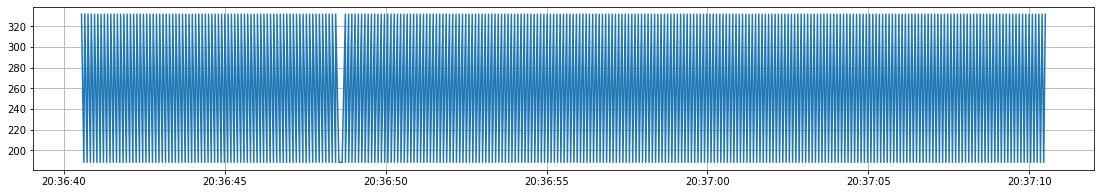

In [89]:
fig, ax = plt.subplots(figsize=(19,3))
plt.plot(df.calibrated0)
plt.grid()

### When the LUT is enabled

In [57]:
await r.mthex.cmd_setCompensationMode.set_start(enable=1, timeout=10)
lutMode = r.mthex.evt_compensationMode.get()
print("compsensation mode enabled?",lutMode.enabled)

compsensation mode enabled? True


In [ ]:
#Switch compensation mode off:
await r.mthex.cmd_setCompensationMode.set_start(enable=0, timeout=10)
lutMode =  r.mthex.evt_compensationMode.get()
print("compsensation mode enabled?",lutMode.enabled)

In [58]:
await printPosition(hex)
a = r.mthex.evt_compensationOffset.get()
print(a.elevation,a.azimuth,a.rotation,a.temperature,a.x,a.y,a.z,a.u,a.v,a.w)

Current Hexapod position
     -0.79    -311.16     267.03      -0.01       0.00       0.00
75.0 0.0 0.0 0.0 -0.8197689278882421 -311.1522845009765 266.9954574997853 -0.008570978028279296 0.0 0.0


In [59]:
async def printUncompensatedAndCompensated(hex):
    posU =  r.mthex.evt_uncompensatedPosition.get()
    print('Uncompensated position')
    print(" ".join(f"{p:10.2f}" for p in [getattr(posU, i) for i in 'xyz']), end = '    ')
    print(" ".join(f"{p:10.6f}" for p in [getattr(posU, i) for i in 'uvw']),'  ',
         pd.to_datetime(posU.private_sndStamp, unit='s'))    
    posC = r.mthex.evt_compensatedPosition.get()
    print('Compensated position')
    print(" ".join(f"{p:10.2f}" for p in [getattr(posC, i) for i in 'xyz']), end = '     ')
    print(" ".join(f"{p:10.6f}" for p in [getattr(posC, i) for i in 'uvw']),'  ',
         pd.to_datetime(posC.private_sndStamp, unit='s'))

await printUncompensatedAndCompensated(hex)

Uncompensated position
      0.00       0.00       0.00      0.000000   0.000000   0.000000    2021-07-09 20:37:47.249085184
Compensated position
     -0.82    -311.15     267.00      -0.008571   0.000000   0.000000    2021-07-09 20:37:47.249408


The inputs to the LUT are currently -
* elevation (from mount telemetry) 
* temperature (mount truss? not implemented yet)
* azimuth (hexapod supports compensation for this input, but model coefficients are not yet configured)
* rotator angle (hexapod supports compensation for this input, but model coefficients are not yet configured

In [73]:
#Only works when mount or mount simulator are active.
mountAngle = await r.mtm.tel_elevation.aget(timeout=10.)
print("mount elevation angle", mountAngle.actualPosition)
elev = mountAngle.actualPosition

mount elevation angle 75.0


In [74]:
#To set the elevation for a controller
#mount.evt_target.set_put(elevation=45)

In [75]:
elevationFixed=80.0

In [76]:
LUTfile = '%s/notebooks/ts_config_mttcs/MTHexapod/v1/default.yaml'%(os.environ["HOME"])
with open(LUTfile, 'r') as stream:
    aa = yaml.safe_load(stream)
if r.mthex.salinfo.index == 1:
    elevCoeff = aa['camera_config']['elevation_coeffs']
    tCoeff = aa['camera_config']['temperature_coeffs']
elif r.mthex.salinfo.index == 2:
    elevCoeff = aa['m2_config']['elevation_coeffs']
    tCoeff = aa['m2_config']['temperature_coeffs']

In [77]:
async def printPredictedComp(elevCoeff, elev):
    '''
    This function deals with the elevation component of the LUT only, for now.
    We will add temperature, azimuth, and rotator angle when they are implemented.
    '''
    pred = []
    print('Predicted LUT compensation:')
    for i in range(6):
        coeff = elevCoeff[i] #starts with C0
        mypoly = np.polynomial.Polynomial(coeff)
        pred.append(mypoly(elev))
    print(" ".join(f"{p:10.2f}" for p in pred))
await printPredictedComp(elevCoeff, elevationFixed)
await printUncompensatedAndCompensated(hex)

Predicted LUT compensation:
     -0.87    -423.42     283.37      -0.01       0.00       0.00
Uncompensated position
      0.00       0.00       0.00      0.000000   0.000000   0.000000    2021-07-09 20:37:47.249085184
Compensated position
     -0.82    -311.15     267.00      -0.008571   0.000000   0.000000    2021-07-09 20:37:47.249408


### Do a slew, then check the LUT again

In [78]:
location = EarthLocation.from_geodetic(lon=-70.747698*u.deg,
                                       lat=-30.244728*u.deg,
                                       height=2663.0*u.m)
print("Current elevation angle = ", elev)

Current elevation angle =  75.0


In [79]:
now = datetime.now()
print("Start to point the telescope", now)

alt = 80. * u.deg
az = 0. * u.deg
rot_tel = Angle(0, unit= u.deg) 

Start to point the telescope 2021-07-09 20:40:23.680952


In [81]:
target_name="TMA motion test"
time_data = await r.mtptg.tel_timeAndDate.next(flush=True, timeout=2)
curr_time_ptg = Time(time_data.mjd, format="mjd", scale="tai")
time_err = curr_time_ptg - Time.now()
print(f"Time error={time_err.sec:0.2f} sec")

print(curr_time_ptg.tai.value)

cmd_elaz = AltAz(alt=alt, az=az, 
                obstime=curr_time_ptg.tai, 
                location=location)
cmd_radec = cmd_elaz.transform_to(ICRS)
# Calculating the other parameters     
rot_pa = rot_tel

Time error=-0.00 sec
59404.86202857038


In [83]:
#Consider to make this simpler by just track in el/az using azElTarget!
#The pointing component is commanding the mount directly
ack = await r.mtptg.cmd_raDecTarget.set_start(
    targetName=target_name,
    frame=MTPtg.CoordFrame.ICRS,
    epoch=2000,  # should be ignored: no parallax or proper motion
    equinox=2000,  # should be ignored for ICRS
    ra=cmd_radec.ra.hour,
    declination=cmd_radec.dec.deg,
    parallax=0,
    pmRA=0,
    pmDec=0,
    rv=0,
    dRA=0,
    dDec=0,
    trackId=9999,
    rotAngle=15.0,
    rotStartFrame=MTPtg.RotFrame.FIXED,
    rotTrackFrame=MTPtg.RotFrame.FIXED,
    rotMode=MTPtg.RotMode.FIELD,
    azWrapStrategy=2,
    timeOnTarget=30,
    timeout=10
)

print(" Now, Waiting 30s")
await asyncio.sleep(30.)
print("System Ready")

 Now, Waiting 30s
System Ready


In [84]:
mountStatus = await r.mtm.evt_axesInPosition.aget(timeout=5.)
rotStatus = await r.mtrot.evt_inPosition.aget(timeout=5.)
print('Are we tracking?', mountStatus.elevation , mountStatus.azimuth , rotStatus.inPosition)

Are we tracking? False False False


In [ ]:
await r.mtptg.cmd_stopTracking.set_start(timeout=5.)

### check angle and LUT after the slew

In [85]:
mountAngle = await r.mtm.tel_elevation.aget(timeout=10.)
print("mount elevation angle", mountAngle.actualPosition)
elev = mountAngle.actualPosition

mount elevation angle 78.82081276195595


In [86]:
await printPosition(hex)
await printUncompensatedAndCompensated(hex)
await printPredictedComp(elevCoeff, elev)

Current Hexapod position
     -0.89    -423.52     283.32      -0.01       0.00      -0.00
Uncompensated position
      0.00       0.00       0.00      0.000000   0.000000   0.000000    2021-07-09 20:37:47.249085184
Compensated position
     -0.87    -423.47     283.37      -0.011594   0.000000   0.000000    2021-07-09 20:41:27.443712512
Predicted LUT compensation:
     -0.86    -396.73     280.12      -0.01       0.00       0.00


### Check if the telescope is in tracking mode. If yes, need to stop stacking. 
The alternative is to check "MT Mount status" dash board on Chronograf. Make sure there are three "False".

In [87]:
mountStatus = r.mtm.evt_axesInPosition.get
rotStatus = r.mtrot.evt_inPosition.get
trackingStatus = mountStatus.elevation and mountStatus.azimuth and rotStatus.inPosition
print('Are we tracking?', trackingStatus)

AttributeError: 'function' object has no attribute 'elevation'

In [ ]:
await ptg.cmd_stopTracking.set_start(timeout=5.)

In [ ]:
#Stop the MTMount controller
await mount.close()